In [59]:
import json
import requests
from bs4 import BeautifulSoup, Comment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

warnings.simplefilter(action="ignore")

### Data crawling 
The data source for this project is at https://fbref.com/en. After spending some time on the website, i was able to identify the key performance metrics for the players. Particularly, i learnt that some statistics might be repeated across several tables. Therefore, i decided to create a JSON file to store the metadata of each table, including their URL, HTML structure, and unique columns. This allows for independency between data source and programming, better managment, as well as cleaner code.

In [2]:
with open(".json", "r") as file:
    source_dict = json.load(file)

SOURCE_URL, STATISTICS_DICT = source_dict["source_url"], source_dict["statistics"]
stats = None

for key, value in STATISTICS_DICT.items():
    container_divs = value["container-divs"]
    columns = value["columns"]

    response = requests.get(SOURCE_URL.format(key))
    html = BeautifulSoup(response.text, features="html.parser")

    stats_div = html.find("body").find(id="wrap").find(id="content").find(id=container_divs[0])
    comment = stats_div.find(string=lambda text: isinstance(text, Comment))
    table = BeautifulSoup(comment, features="html.parser").find(id=container_divs[1]).find("table")

    tr_list = table.find("tbody").find_all("tr")
    tr_list = [tr for tr in tr_list if not tr.has_attr("class")]
    stats_list = []
    for tr in tr_list:
        player_stats = {td.get("data-stat"): td.text for td in tr.find_all("td") if td.get("data-stat") in columns}
        stats_list.append(player_stats)

    if isinstance(stats, pd.DataFrame):
        stats = stats.merge(
            pd.DataFrame(stats_list).set_index(["player", "team"]),
            on=["player", "team"],
            how="left"
        )
    else:
        stats = pd.DataFrame(stats_list).set_index(["player", "team"])
        stats["minutes"] = stats["minutes"].str.replace(",", "").astype(float)
        stats = stats[stats["minutes"] >= 90]

stats

,,nationality,position,age,minutes,goals_assists,goals_pens,npxg_xg_assist,goals_per90,assists_per90,goals_assists_per90,...,cards_red,fouls,fouled,offsides,crosses,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct
player,team,,,,,,,,,,,,,,,,,,,,,
Max Aarons,Bournemouth,eng ENG,DF,23,1237.0,1,0,0.9,0.00,0.07,0.07,...,0,12,26,2,13,0,75,5,11,31.3
Tyler Adams,Bournemouth,us USA,MF,24,121.0,0,0,0.1,0.00,0.00,0.00,...,0,0,3,0,1,0,7,2,3,40.0
Tosin Adarabioyo,Fulham,eng ENG,DF,25,1617.0,2,2,0.8,0.11,0.00,0.11,...,0,10,5,0,1,0,43,56,28,66.7
Elijah Adebayo,Luton Town,eng ENG,FW,25,1419.0,10,10,6.6,0.63,0.00,0.63,...,0,27,16,13,5,0,34,43,43,50.0
Simon Adingra,Brighton,ci CIV,FW,21,2222.0,7,6,8.0,0.24,0.04,0.28,...,0,29,19,17,76,0,118,8,12,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nicolò Zaniolo,Aston Villa,it ITA,"FW,MF",24,839.0,2,2,3.6,0.21,0.00,0.21,...,0,24,21,0,18,0,36,7,14,33.3
Anass Zaroury,Burnley,ma MAR,"FW,MF",22,152.0,0,0,0.2,0.00,0.00,0.00,...,1,4,3,0,11,0,8,0,1,0.0
Oleksandr Zinchenko,Arsenal,ua UKR,DF,26,1722.0,3,1,3.1,0.05,0.10,0.16,...,0,7,9,1,30,0,104,27,16,62.8


### Data cleaning
- There is redundancy at the **_nationality_** column
- Since the data was read from an HTML response, all of the columns now are defined as string, which requires type conversion as the statistical data needs to be numerical for later use. Notably, the missing data is represented as blank

In [3]:
stats["nationality"] = stats["nationality"].str.replace(r"[a-z]", "", regex=True)
stats = stats.replace("", np.nan)

statistical_columns = stats.columns.difference(["nationality", "position"])
statistical_columns.name = "statistical_columns"
stats[statistical_columns] = stats[statistical_columns].astype(float)
stats.dtypes

nationality         object
position            object
age                float64
minutes            float64
goals_assists      float64
                    ...   
own_goals          float64
ball_recoveries    float64
aerials_won        float64
aerials_lost       float64
aerials_won_pct    float64
Length: 158, dtype: object

In [45]:
stats.reset_index().sort_values(by=["player", "age"], ascending=[True, False]).set_index(["player", "team"]).to_csv("result/results.csv", index=True)

### Q1: Who are the top 3 players with the highest and lowest scores at each statistic?
Players are sorted from lowest (-3) to highest (3) in the following table

In [5]:
top_and_bottom_stats = pd.concat([
    stats[statistical_columns].apply(lambda col: col.nsmallest(3).sort_values().index.values).set_axis([-3, -2, -1]),
    stats[statistical_columns].apply(lambda col: col.nlargest(3).sort_values().index.values).set_axis([1, 2, 3])
])
top_and_bottom_stats

,aerials_lost,aerials_won,aerials_won_pct,age,assisted_shots,assists,assists_per90,average_shot_distance,ball_recoveries,blocked_passes,...,touches_live_ball,touches_mid_3rd,unused_subs,xg,xg_assist,xg_assist_net,xg_assist_per90,xg_net,xg_per90,xg_xg_assist_per90
-3,"(Daniel Bentley, Wolves)","(Maxwel Cornet, West Ham)","(Maxwel Cornet, West Ham)","(Leon Chiwome, Wolves)","(Jaidon Anthony, Bournemouth)","(Tyler Adams, Bournemouth)","(Tyler Adams, Bournemouth)","(Tim Ream, Fulham)","(Loris Karius, Newcastle Utd)","(Alisson, Liverpool)",...,"(Leon Chiwome, Wolves)","(Dean Henderson, Crystal Palace)","(Elijah Adebayo, Luton Town)","(Max Aarons, Bournemouth)","(Naouirou Ahamada, Crystal Palace)","(Dejan Kulusevski, Tottenham)","(Alisson, Liverpool)","(Dominic Calvert-Lewin, Everton)","(Max Aarons, Bournemouth)","(Alisson, Liverpool)"
-2,"(Martin Dúbravka, Newcastle Utd)","(Mahmoud Dahoud, Brighton)","(Mahmoud Dahoud, Brighton)","(Lewis Miley, Newcastle Utd)","(Alphonse Areola, West Ham)","(Tosin Adarabioyo, Fulham)","(Tosin Adarabioyo, Fulham)","(Andrew Omobamidele, Nott'ham Forest)","(Ionuț Radu, Bournemouth)","(Alphonse Areola, West Ham)",...,"(Neal Maupay, Everton)","(Loris Karius, Newcastle Utd)","(Anel Ahmedhodžić, Sheffield Utd)","(Tyler Adams, Bournemouth)","(Alisson, Liverpool)","(Bruno Fernandes, Manchester Utd)","(Jaidon Anthony, Bournemouth)","(Brennan Johnson, Tottenham)","(Tyler Adams, Bournemouth)","(Alphonse Areola, West Ham)"
-1,"(Ederson, Manchester City)","(Tommy Doyle, Wolves)","(Tommy Doyle, Wolves)","(Facundo Buonanotte, Brighton)","(Daniel Bentley, Wolves)","(Elijah Adebayo, Luton Town)","(Elijah Adebayo, Luton Town)","(Jonny Evans, Manchester Utd)","(Thomas Strakosha, Brentford)","(Daniel Bentley, Wolves)",...,"(Loris Karius, Newcastle Utd)","(Ionuț Radu, Bournemouth)","(Rayan Aït-Nouri, Wolves)","(Alisson, Liverpool)","(Jaidon Anthony, Bournemouth)","(Dominik Szoboszlai, Liverpool)","(Alphonse Areola, West Ham)","(Darwin Núñez, Liverpool)","(Alisson, Liverpool)","(Daniel Bentley, Wolves)"
1,"(Dominic Solanke, Bournemouth)","(Dominic Calvert-Lewin, Everton)","(Daniel Bentley, Wolves)","(Łukasz Fabiański, West Ham)","(Martin Ødegaard, Arsenal)","(Kevin De Bruyne, Manchester City)","(Kevin De Bruyne, Manchester City)","(Moisés Caicedo, Chelsea)","(Ryan Christie, Bournemouth)","(João Palhinha, Fulham)",...,"(Lewis Dunk, Brighton)","(William Saliba, Arsenal)","(Aaron Ramsdale, Arsenal)","(Alexander Isak, Newcastle Utd)","(Bruno Fernandes, Manchester Utd)","(Pedro Neto, Wolves)","(Sasa Kalajdzic, Wolves)","(Jean-Philippe Mateta, Crystal Palace)","(Erling Haaland, Manchester City)","(Erling Haaland, Manchester City)"
2,"(Dominic Calvert-Lewin, Everton)","(James Tarkowski, Everton)","(Martin Dúbravka, Newcastle Utd)","(Thiago Silva, Chelsea)","(Pascal Groß, Brighton)","(Cole Palmer, Chelsea)","(Ivan Perišić, Tottenham)","(Kyle Walker, Manchester City)","(Rodri, Manchester City)","(Tyrick Mitchell, Crystal Palace)",...,"(Pascal Groß, Brighton)","(Virgil van Dijk, Liverpool)","(Thomas Strakosha, Brentford)","(Mohamed Salah, Liverpool)","(Son Heung-min, Tottenham)","(Rodri, Manchester City)","(Ivan Perišić, Tottenham)","(Callum Hudson-Odoi, Nott'ham Forest)","(Neal Maupay, Everton)","(Neal Maupay, Everton)"
3,"(Carlton Morris, Luton Town)","(Virgil van Dijk, Liverpool)","(Ederson, Manchester City)","(Ashley Young, Everton)","(Bruno Fernandes, Manchester Utd)","(Ollie Watkins, Aston Villa)","(Manor Solomon, Tottenham)","(Oliver Norwood, Sheffield Utd)","(Bruno Guimarães, Newcastle Utd)","(Alexis Mac Allister, Liverpool)",...,"(Rodri, Manchester City)","(Rodri, Manchester City)","(Daniel Bentley, Wolves)","(Erling Haaland, Manchester City)","(Mohamed Salah, Liverpool)","(Ollie Watkins, Aston Villa)","(Kevin De Bruyne, Manchester City)","(Phil Foden, Manchester City)","(Kieffer Moore, Bournemouth)","(Kieffer Moore, Bournemouth)"


### Q2: Which team is performing the best overall during the season?
#### 1. Caculate median, mean and standard deviation for every statistic in each team

In [11]:
statistics = ["median", "mean", "std", "sum"]

all_team_stats = pd.DataFrame(
    [stats[statistical_columns].agg(statistics).T.to_numpy().flatten()],
    columns=pd.MultiIndex.from_product([statistical_columns.array, statistics]),
    index=pd.Index(["All"], name="team")
)

team_stats = pd.concat([
    all_team_stats,
    stats[statistical_columns].groupby(level="team").agg(statistics)
])
team_stats

aerials_lost                                aerials_won  \
                      median       mean        std      sum      median   
team                                                                      
All                     16.0  20.402834  20.973606  10079.0        12.0   
Arsenal                 16.0  23.619048  24.830377    496.0        15.0   
Aston Villa             14.0  15.695652  16.457755    361.0        13.0   
Bournemouth             21.0  25.653846  29.389716    667.0        15.0   
Brentford               23.0  24.000000  16.849827    600.0        14.0   
Brighton                11.5  12.214286   8.808065    342.0         7.5   
Burnley                 22.0  24.714286  23.325169    692.0        13.5   
Chelsea                 14.0  15.880000  13.860375    397.0         9.0   
Crystal Palace          17.0  23.125000  20.749673    555.0        12.5   
Everton                 19.0  25.086957  31.137398    577.0        16.0   
Fulham                  19.0  23.666667  23.789353    497.0        13.0   
Liverpool               14.0  19.954545  14.486372    439.0        15.5   
Luton Town              16.0  25.200000  33.117216    630.0        17.0   
Manchester City          8.0  13.666667  13.312901    287.0         6.0   
Manchester Utd          18.0  17.115385  14.182600    445.0        13.5   
Newcastle Utd           12.0  16.440000  16.416658    411.0        10.0   
Nott'ham Forest         10.0  18.500000  21.634503    555.0        14.0   
Sheffield Utd           16.0  23.066667  23.619007    692.0         8.0   
Tottenham               14.5  15.916667  14.303896    382.0         8.5   
West Ham                23.0  25.590909  23.526397    563.0        20.0   
Wolves                  21.0  19.640000  14.679578    491.0         8.0   

                                               aerials_won_pct             \
                      mean        std      sum          median       mean   
team                                                                        
All              20.447368  23.820838  10101.0           46.90  48.338809   
Arsenal          23.809524  28.002891    500.0           48.80  48.830000   
Aston Villa      14.478261  12.943477    333.0           50.00  53.656522   
Bournemouth      22.192308  23.901497    577.0           42.10  45.768000   
Brentford        25.240000  26.833251    631.0           45.60  46.050000   
Brighton         14.464286  17.045651    405.0           45.70  47.935714   
Burnley          20.035714  26.141328    561.0           43.75  40.807143   
Chelsea          17.120000  17.965986    428.0           47.20  49.976000   
Crystal Palace   22.916667  24.207287    550.0           48.50  50.266667   
Everton          29.391304  40.626614    676.0           47.20  47.827273   
Fulham           22.809524  19.314811    479.0           52.20  50.238095   
Liverpool        26.454545  30.722610    582.0           53.60  54.268182   
Luton Town       25.400000  27.605857    635.0           50.00  53.168000   
Manchester City  15.476190  17.965576    325.0           50.00  49.730000   
Manchester Utd   16.769231  15.895427    436.0           44.95  47.261538   
Newcastle Utd    18.080000  23.575976    452.0           47.70  51.170833   
Nott'ham Forest  19.366667  18.219889    581.0           54.50  55.796552   
Sheffield Utd    19.500000  26.502765    585.0           45.35  41.666667   
Tottenham        14.750000  18.531407    354.0           38.50  41.500000   
West Ham         25.909091  26.354559    570.0           50.95  50.490909   
Wolves           17.640000  21.990301    441.0           41.90  43.344000   

                 ...    xg_net               xg_per90                      \
                 ...       std           sum   median      mean       std   
team             ...                                                        
All              ...  1.383082 -6.000000e+00    0.080  0.148684  0.177505   
Arsenal          ...  1.542277  8.000000e+00    0.120  0.1

In [7]:
# team_stats.to_csv("result/results2.csv", index=True)

#### 2. Visualize the distribution of each statistic for every team

In [8]:
AXES_PER_ROW = 4
NUM_ROWS = (statistical_columns.size + AXES_PER_ROW - 1) // AXES_PER_ROW

def histplot(team=None):
    fig, axes = plt.subplots(NUM_ROWS, AXES_PER_ROW, figsize=(15, 5 * NUM_ROWS))
    fig.suptitle(team if team else "All", y=1)
    axes = axes.flatten()

    data = stats.xs(team, level="team") if team else stats
    for i, column in enumerate(statistical_columns):
        sns.histplot(data[column], ax=axes[i], bins=10, kde=True)
        
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [9]:
# for team in pd.Index([None]).append(stats.index.unique(level="team")):
#     histplot(team=team)

#### 3. Identify the team with the highest score at each statistic

In [14]:
top_team_stats = team_stats.iloc[1:].xs(axis=1, key="sum", level=1).apply(lambda col: col.idxmax()).to_frame().T
top_team_stats

,aerials_lost,aerials_won,aerials_won_pct,age,assisted_shots,assists,assists_per90,average_shot_distance,ball_recoveries,blocked_passes,...,touches_live_ball,touches_mid_3rd,unused_subs,xg,xg_assist,xg_assist_net,xg_assist_per90,xg_net,xg_per90,xg_xg_assist_per90
0,Burnley,Everton,Nott'ham Forest,Nott'ham Forest,Liverpool,Manchester City,Tottenham,Nott'ham Forest,Liverpool,Liverpool,...,Manchester City,Manchester City,Manchester City,Liverpool,Liverpool,Manchester City,Tottenham,Manchester City,Bournemouth,Bournemouth


#### 4. which team had the best overall performance?
A good performance shall not be infered by all of the statistics. This is because there're some that may indicate bad performance, such as goal keeping losses, yellow cards, or red cards, ... A more appropiate approach would be using those that are considered as positive statistics only. Thus, we must define what we mean by "positive statistics". Well, by intuition, we would instantly think of the number of goals as arguably the best indicator of a good performance. Therefore, the positive statistics understandably are the ones which are proportional to the number of goals.

In [20]:
goal_correlation = stats[statistical_columns].apply(lambda col: stats["goals"].corr(col))
positive_statistical_columns = goal_correlation[goal_correlation >= 0.5]
positive_statistical_columns

c:\Users\caohu\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\caohu\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


assisted_shots                 0.580624
assists                        0.582493
carries_into_penalty_area      0.605928
dispossessed                   0.681451
fouled                         0.524454
gca                            0.676618
gca_passes_live                0.599781
gca_shots                      0.511540
gca_take_ons                   0.547876
goals                          1.000000
goals_assists                  0.934015
goals_assists_pens_per90       0.652618
goals_assists_per90            0.693949
goals_pens                     0.980669
goals_pens_per90               0.688210
goals_per90                    0.744930
miscontrols                    0.725661
npxg                           0.920021
npxg_per90                     0.576860
npxg_xg_assist                 0.888042
npxg_xg_assist_per90           0.583464
offsides                       0.673832
pass_xa                        0.577866
passes_into_penalty_area       0.503335
pens_att                       0.633967


##### Method 1
The team with the best overall performance could be the one that top most of the statistics

In [21]:
top_team_stats.iloc[0][positive_statistical_columns.index].value_counts()[:3]

0
Liverpool          11
Manchester City    11
Bournemouth         6
Name: count, dtype: int64

##### Method 2
Or we can calculate a score to describe the overall performance, and the one with the highest score is the best team. There're various ways to implement this abstract concept. One example could be the norm (magnitude) of vector

In [22]:
team_stats.loc[team_stats.index[1] : , positive_statistical_columns.index].xs(axis=1, key="sum", level=1).apply(lambda row: np.sqrt((row ** 2).sum()), axis=1).sort_values(ascending=False)[:3]

team
Manchester City    10828.525181
Arsenal             9183.536999
Tottenham           8658.729828
dtype: float64

##### Conclusion
Both of the methods yield the same result where Manchester City is shown to have outperformed the other teams
### Q3: Are there different playing styles among the players?
The k-mean algorithm requires the data to be nan-free. And, to address this, we replace the nan values of a player by the medians of the team he's in (medians behave more stable toward outliners compared to means).  

In [ ]:
nan_free_stats = stats.reset_index(level="player")[statistical_columns].apply(lambda col: col.fillna(team_stats[(col.name, "median")]))

Several techniques can be used to find the best number for clusters in clustering. An easy one would by using the elbow method, where we create a scree plot and determine the "elbow" point (the optimal k). The elbow is where the curve starts to flatten, so according to the following graph, number **5** seems to be the perfect candidate.

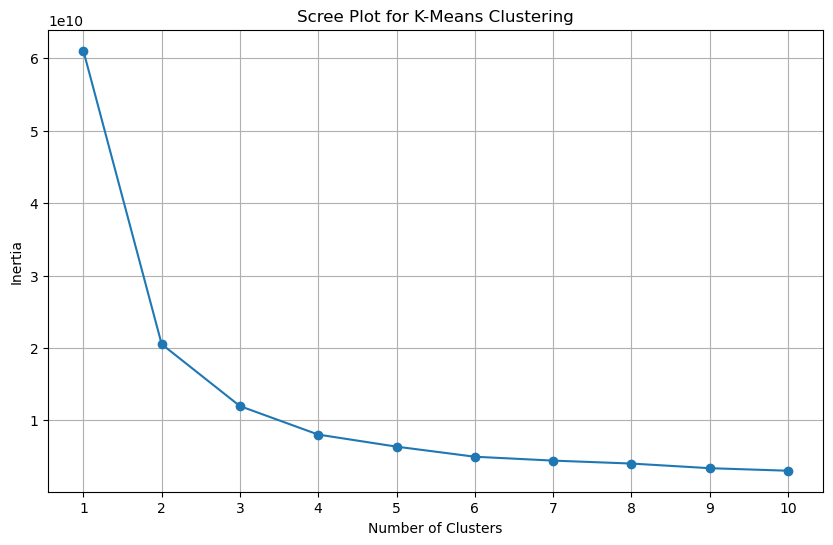

In [20]:
range_n_clusters = range(1, 11)
inertia = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(nan_free_stats)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Scree Plot for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()

In [41]:
K = 5
kmeans = KMeans(n_clusters=K, random_state=0)
kmeans.fit(nan_free_stats)

KMeans(n_clusters=5, random_state=0)

To be able to view the result of clustering, we shall perform dimension reduction to 2D-dimension. For this task, PCA will do nicely

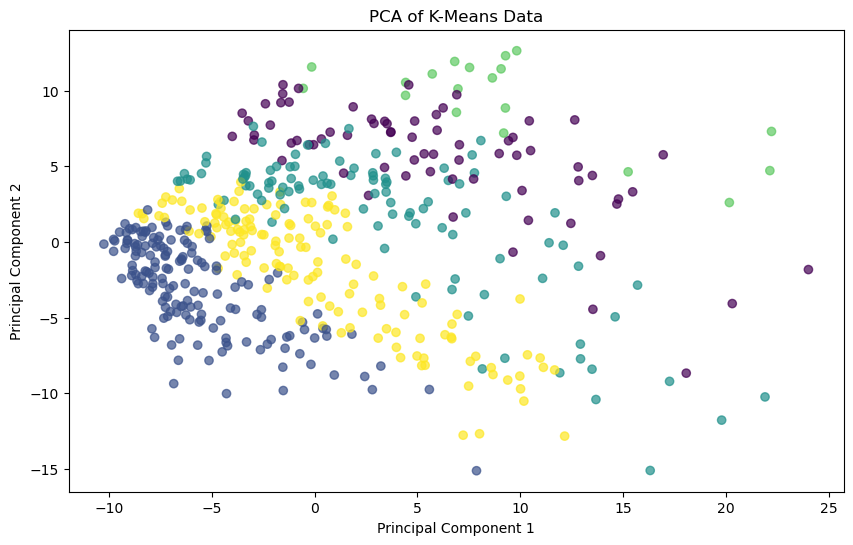

In [42]:
pca = PCA(n_components=2)
stats_pca = pca.fit_transform(StandardScaler().fit_transform(nan_free_stats))
plt.figure(figsize=(10, 6))
plt.scatter(stats_pca[:, 0], stats_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7)
plt.title('PCA of K-Means Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Interpretation of the two principal components should be further discussed. However, it requires a strong base of the domain knowledge, which is football. And, I must admit having no expertise in this field, so unfortunately this section is temporarily omitted for now.

In [43]:
pc1, pc2 = pca.components_
pc1 = pd.Series(pc1, index=statistical_columns)
pc2 = pd.Series(pc2, index=statistical_columns)
print(pc1.nlargest(5), pc2.nlargest(5), sep="\n\n")

statistical_columns
sca                0.133084
sca_passes_live    0.132149
touches_att_3rd    0.129159
assisted_shots     0.124362
pass_xa            0.123789
dtype: float64

statistical_columns
touches_def_3rd                0.156854
passes_progressive_distance    0.142994
passes_completed_medium        0.135816
passes_total_distance          0.132971
passes_medium                  0.132086
dtype: float64


### Q4: Compare players through radar chart
First of all, we need to prepare the data. Scaling data between 0 and 1 is crucial for using a radar chart, preventing any single variable from disproportionately influencing the visualization.

In [86]:
pd.DataFrame(
    MinMaxScaler().fit_transform(nan_free_stats),
    index=stats.index.get_level_values("player"),
    columns=statistical_columns
).to_csv("result/standard_results.csv")

Here is a Python program to draw a radar chart comparing two players with the following inputs:
- The name of the two players
- The list of statistics to be compared
---
**radarChartPlot.py**
```python
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()
parser.add_argument('--p1', type=str, help="The name of the first player")
parser.add_argument('--p2', type=str, help="The name of the second player")
parser.add_argument('--attribute', nargs='+', help="The list of statistics to be compared")

args = parser.parse_args()
p1_name = args.p1
p2_name = args.p2
cols = pd.Index(args.attribute)

stats = pd.read_csv("result/standard_results.csv", index_col="player")

diff_columns = cols.difference(stats.columns)
if not diff_columns.empty:
    raise ValueError(f"{diff_columns.array} are not supported")

p1 = stats.loc[p1_name, cols].values.flatten().tolist()
p2 = stats.loc[p2_name, cols].values.flatten().tolist()

p1.append(p1[0])
p2.append(p2[0])

angles = np.linspace(0, 2 * np.pi, cols.size, endpoint=False).tolist()
angles.append(angles[0])

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], cols.values)
ax.set_ylim(0, 1)

ax.plot(angles, p1, color='red', linewidth=2, label=p1_name)
ax.fill(angles, p1, color='red', alpha=0.25)

ax.plot(angles, p2, color='blue', linewidth=2, label=p2_name)
ax.fill(angles, p2, color='blue', alpha=0.25)

plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()
```
---
**Powershell**
```powershell
python radarChartPlot.py --p1 'Elijah Adebayo' --p2 'Zeki Amdouni' --attribute aerials_lost aerials_won aerials_won_pct age average_shot_distance ball_recoveries gk_clean_sheets blocked_passes
```

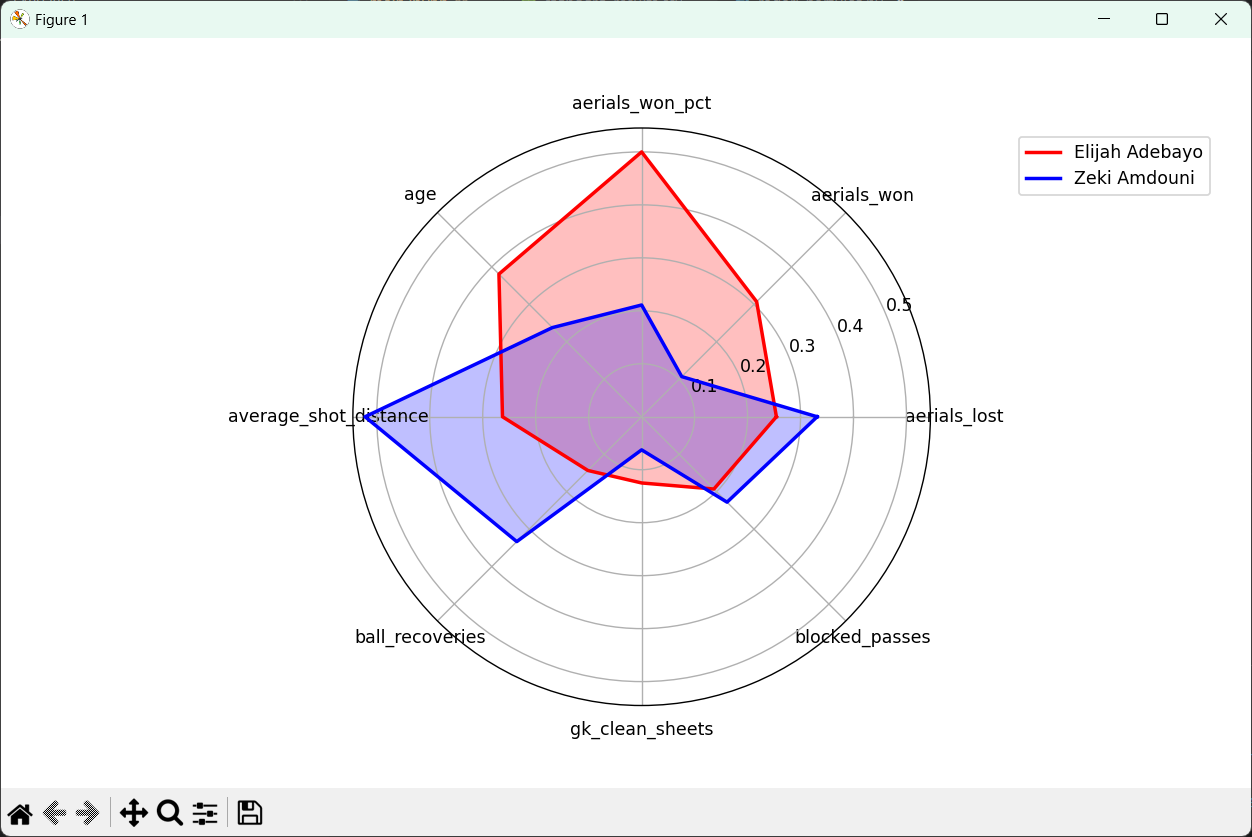